# **Fooling AI image classifers**
#### by Outmani Ossama

# A. Introduction

## 1. Getting used with the model

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np

2024-04-04 11:22:41.046130: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 11:22:41.913381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 11:22:41.913486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 11:22:42.152197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 11:22:42.534755: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 11:22:42.535421: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  1.a. load the model

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

# function to get the predicted label
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

###  1.b. get the image

In [ ]:
# comment this cell if you are runnning this notebook locally
from google.colab import files

def read_image(image_path=None):
  if image_path is None:
    uploaded = files.upload()
    image_path=list(uploaded.keys())[0]
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  return image


In [3]:
# comment this cell if you are runnning this notebook in Collab
def read_image(image_path=None):
  if image_path is None:
    image_path=input("Please enter the image path")
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  return image

In [4]:
# default image
image = read_image(image_path="cat6.jpg")

# to upload your own image
# image = read_image()

###  1.c. Preprocess the image

In [5]:
#used only to preprocess the original image
def preprocess_org(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  return resized_image

In [6]:
#preprecess the image to be compatible with the model
def preprocess(photo):
  resized_image=tf.image.resize(photo,(224,224))
  resized_image=resized_image[None,...]
  preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)
  return preprocessed_image

In [7]:
preprocessed_image=preprocess(image)

###  1.d. Predict the label

In [8]:
import json

#return one_hot encoding corresponding to given label
def one_hot_from_label(label,size=1000):
  with open("imageNet.json","r") as f:
    labels_dict=json.load(f)
  index=labels_dict[label]
  label_array = tf.one_hot(index, size)
  label_array = tf.reshape(label_array, (1,size))

  return label_array

In [9]:
#probilities of each label for the given image
def mobilenet_v2_predict(image):
  preprocessed_image=preprocess(image)
  predictions=pretrained_model.predict(preprocessed_image,verbose="0")
  decoded_prediction=decode_predictions(predictions,top=1)[0]

  loss_object = tf.keras.losses.CategoricalCrossentropy()
  label=decoded_prediction[0][1]
  one_hot_label=one_hot_from_label(label)
  loss = loss_object(one_hot_label, predictions)
  return {"predictions" : predictions ,"loss" : loss}

In [10]:
# get label and confidence level for an image
def get_class(probabilities):
  _ , label , confidence = decode_predictions(probabilities,top=1)[0][0]
  return {"label":label,"confidence":confidence}

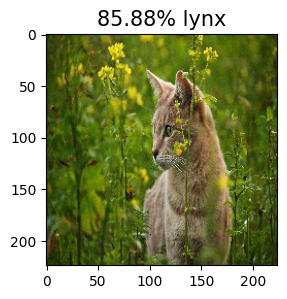

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (3, 3)
mpl.rcParams['axes.grid'] = False

#display given image along with prediction information
def display_prediction(image,xlabel=None):
    plt.figure()
    img_ajusted=np.asarray(preprocess_org(image)).reshape(224,224,3)
    plt.imshow(img_ajusted/255)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}",fontsize="15")
    if xlabel is not None:
        plt.xlabel(xlabel,fontsize="13")

display_prediction(image)

## 2. Building Adversarial exemples

In [12]:
#generate noise for a given image
def generate_adversarial_noise(image,type="sign"):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]
    one_hot_label=one_hot_from_label(label)
    image=preprocess(image)
    with tf.GradientTape() as tape:
      tape.watch(image)
      predictions = pretrained_model(image)
      loss = loss_object(one_hot_label, predictions)
    gradient = tape.gradient(loss, image)    # Get the gradients of the loss with respect to the input image.

    if type=="sign": # Get the sign of the gradients to create the perturbation
      signed_grad = tf.sign(gradient)  
      return signed_grad
    
    elif type=="norm": # Get the normalize version of the gradients to create the perturbation
      max_grad = tf.reduce_max(tf.math.abs(gradient)) 
      return gradient/max_grad

## 3. Visualising

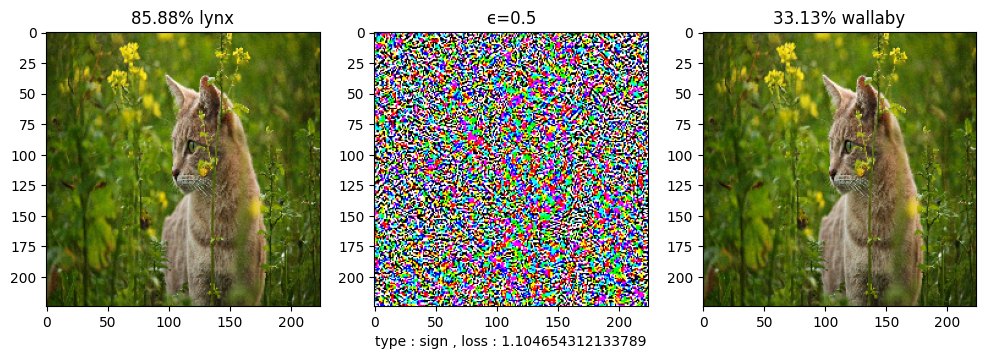

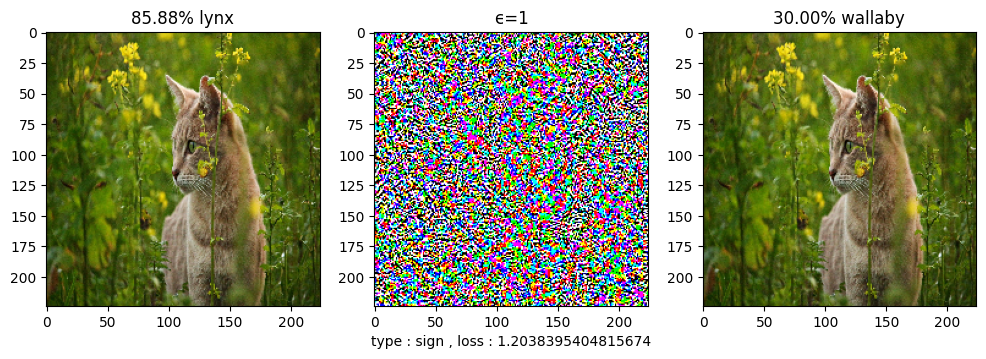

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

#display before and after and noise of a given image after FGSM
def display_exemples(image,epsilon=[0.07],type="sign"):
  i=1
  for e in epsilon :
    plt.figure(i)
    plt.subplot(231)
    noise=generate_adversarial_noise(image,type=type)
    img_ajusted=np.asarray(preprocess_org(image)).reshape(224,224,3)
    plt.imshow(img_ajusted/255)
    prediction=mobilenet_v2_predict(image)
    label,confidence=get_class(mobilenet_v2_predict(image)["predictions"]).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    label=get_class(mobilenet_v2_predict(image)["predictions"])["label"]


    plt.subplot(233)
    adv_image=preprocess_org(image)+e*noise
    adv_image=tf.clip_by_value(adv_image,0,255)
    prediction_couple=mobilenet_v2_predict(tf.reshape(adv_image,(224,224,3)))["predictions"]
    label,confidence=get_class(prediction_couple).values()
    plt.title(f"{confidence*100:.2f}% {label}")
    adv_ajusted=tf.reshape(adv_image,(224,224,3))
    loss_object = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0)
    one_hot_label=one_hot_from_label(label)
    loss = loss_object(one_hot_label, prediction_couple)

    plt.imshow(adv_ajusted/tf.reduce_max(tf.math.abs(adv_ajusted)))
    # plt.xlabel(f"type : {type} , loss : {loss}")
    
    plt.subplot(232)
    plt.title(f"ϵ={e}")
    plt.xlabel(f"type : {type} , loss : {loss}")

    plt.imshow(np.asarray(noise*0.5+0.5).reshape(224,224,3))

    i+=1


display_exemples(image,[0.5,1],"sign")

# B. Paper Experiments

In [14]:
img=read_image("cat6.jpg")

## Experiment 1 : FGSM

applying FGSM to an image

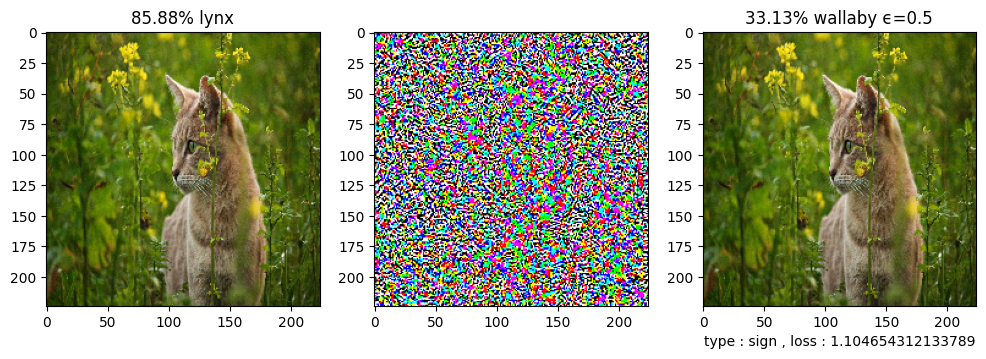

In [15]:
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
display_exemples(img,[0.5],"sign")

## Experiment 2 : FGSM with multiple epsilons

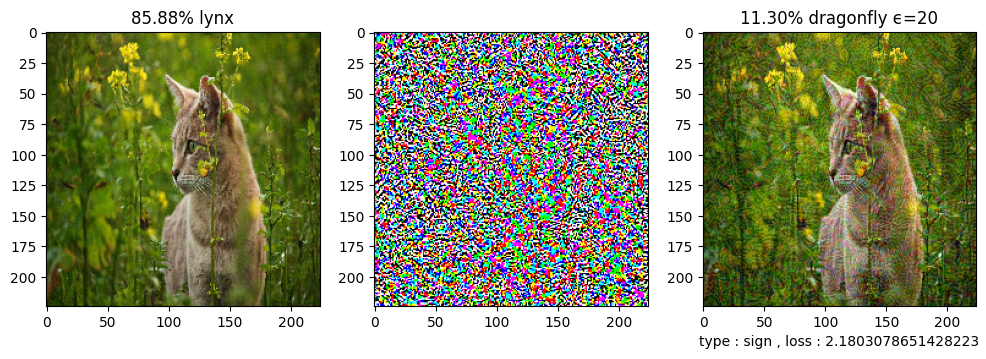

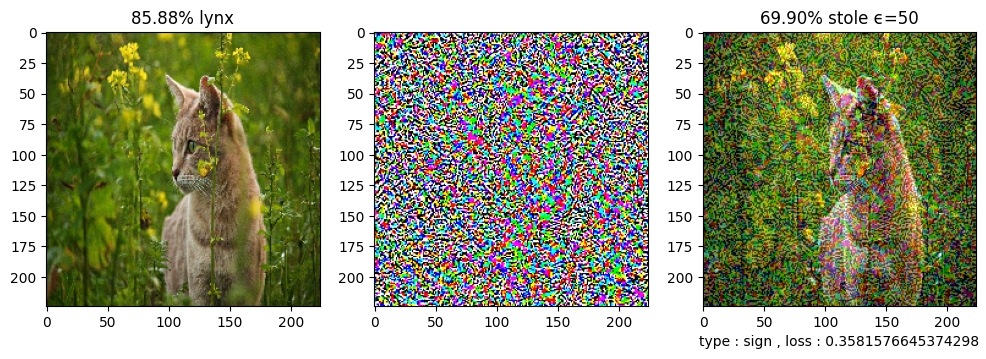

In [20]:
display_exemples(img,[20,50],"sign")

## Experiment 3 : optimizing FGSM

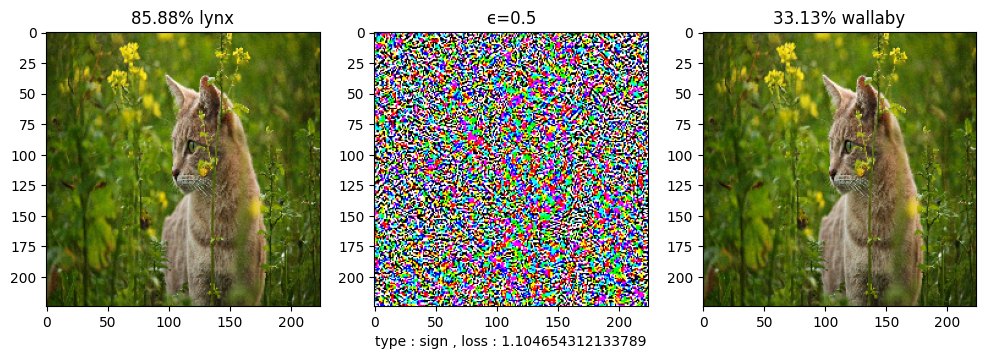

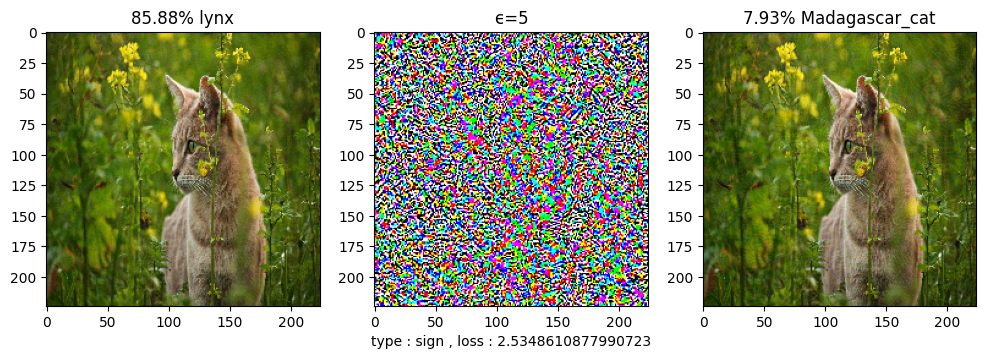

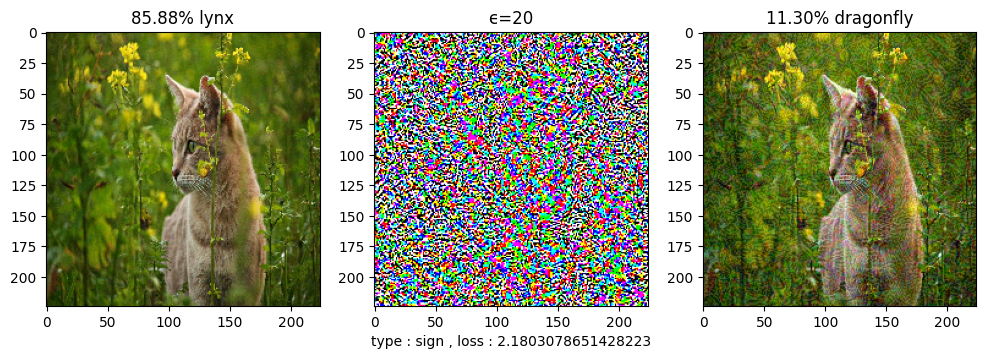

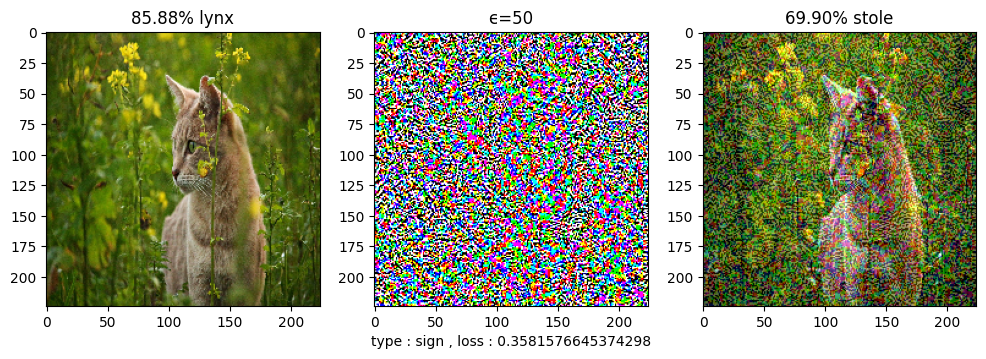

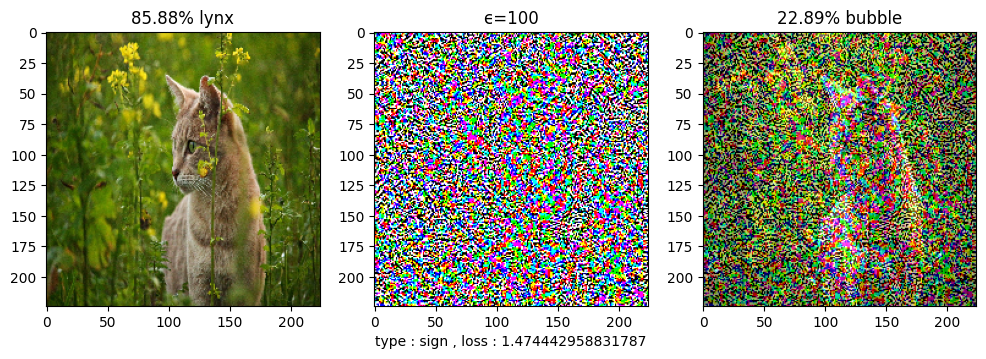

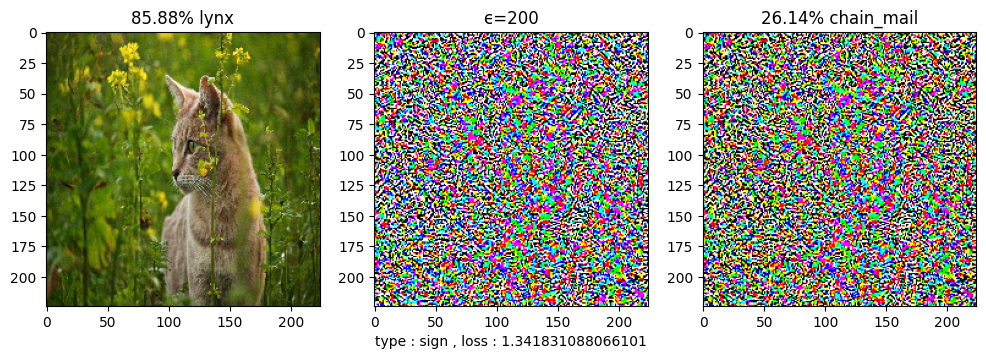

In [29]:
display_exemples(img,[0.5,5,20,50,100,200],"norm")